In [1]:
import sys
sys.path.append("/home/huaqingj/MyResearch/TVDN")

In [2]:
from pyTVDN import TVDNDetect, TVDNRankTuning
from pathlib import Path
from scipy.io import loadmat
from scipy.signal import detrend
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from collections import defaultdict as ddict
from tqdm import tqdm_notebook as tqdm
import pickle
%matplotlib inline
plt.style.use('ggplot')

In [3]:
from scipy.signal import lfilter, firls, decimate

In [4]:
saveDir = Path("./fMRIHPFs")

In [5]:
fils = list(saveDir.glob("*.pkl"))

In [6]:
fils = sorted(fils, key=lambda x: int(x.stem.split("_")[-1]))

In [7]:
import rpy2.robjects as robj

In [8]:
robj.r.source("../Rcode/utils.R")

value,[RTYPES.CLOSXP]
visible,[RTYPES.LGLSXP]


In [9]:
def py2Rmat(Mat):
    Mat = np.array(Mat)
    nrow, _ = Mat.shape
    rVec = robj.FloatVector(Mat.ravel())
    rMat = robj.r.matrix(rVec, nrow=nrow, byrow=True)
    return rMat

In [10]:
def py2Rvec(vec):
    vec = np.array(vec)
    vec = vec.astype(np.float)
    return robj.FloatVector(vec)

In [11]:
RsegCorr = robj.r["segCorr"]
RsegPCA = robj.r["segPCA"]
RsegDMD = robj.r["DMD"]
RchgF = robj.r["chgF"]

# Distribution of num of changes under DCOR, DMD, PCA methods

In [12]:
wsize = 10
rank = 6
numChgsw10 = ddict(list)
for fil in tqdm(fils):
    with open(fil, "rb") as f:
        res = pickle.load(f)
    Ymat = res.DetectObj.Ymat
    d, n = Ymat.shape
    seqw = np.arange(2, n-wsize, 4)
    rSeqw = py2Rvec(seqw)
    rYmat = py2Rmat(Ymat)
    
    
    rDCORres = RsegCorr(rYmat, wsize, rSeqw)
    rDCORecpts = RchgF(rDCORres, rSeqw)
    numChgsw10["DCOR"].append(np.array(rDCORecpts))
    
    # Detection results for PCA
    rPCAres = RsegPCA(rYmat, wsize, rSeqw, rank=rank)
    rPCAecpts = RchgF(rPCAres, rSeqw)
    numChgsw10["PCA"].append(np.array(rPCAecpts))
    
    # Detection results for DMD
    rDMDres = RsegDMD(rYmat, wsize, rSeqw, rank=rank)
    rDMDecpts = RchgF(rDMDres, rSeqw)
    numChgsw10["DMD"].append(np.array(rDMDecpts))

In [13]:
wsize = 20
rank = 6
numChgsw20 = ddict(list)
for fil in tqdm(fils):
    with open(fil, "rb") as f:
        res = pickle.load(f)
    Ymat = res.DetectObj.Ymat
    d, n = Ymat.shape
    seqw = np.arange(2, n-wsize, 4)
    rSeqw = py2Rvec(seqw)
    rYmat = py2Rmat(Ymat)
    
    # Detection results for DCOR
    rDCORres = RsegCorr(rYmat, wsize, rSeqw)
    rDCORecpts = RchgF(rDCORres, rSeqw)
    numChgsw20["DCOR"].append(np.array(rDCORecpts))
    
    # Detection results for PCA
    rPCAres = RsegPCA(rYmat, wsize, rSeqw, rank=rank)
    rPCAecpts = RchgF(rPCAres, rSeqw)
    numChgsw20["PCA"].append(np.array(rPCAecpts))
    
    # Detection results for DMD
    rDMDres = RsegDMD(rYmat, wsize, rSeqw, rank=rank)
    rDMDecpts = RchgF(rDMDres, rSeqw)
    numChgsw20["DMD"].append(np.array(rDMDecpts))

In [14]:
numChgs10CT = {}
numChgs20CT = {}
for key, v in numChgsw10.items():
    CT = Counter([len(ecpt) for ecpt in v])
    chgs = list(CT.keys())
    chgCts = [CT[chg] for chg in chgs]
    numChgs10CT[key] = [chgs, chgCts]
    
for key, v in numChgsw20.items():
    CT = Counter([len(ecpt) for ecpt in v])
    chgs = list(CT.keys())
    chgCts = [CT[chg] for chg in chgs]
    numChgs20CT[key] = [chgs, chgCts]

### The num of changes is sensitive to window size for DCOR, PCA or DMD methods

Text(0.07, 0.25, 'wsize=20')

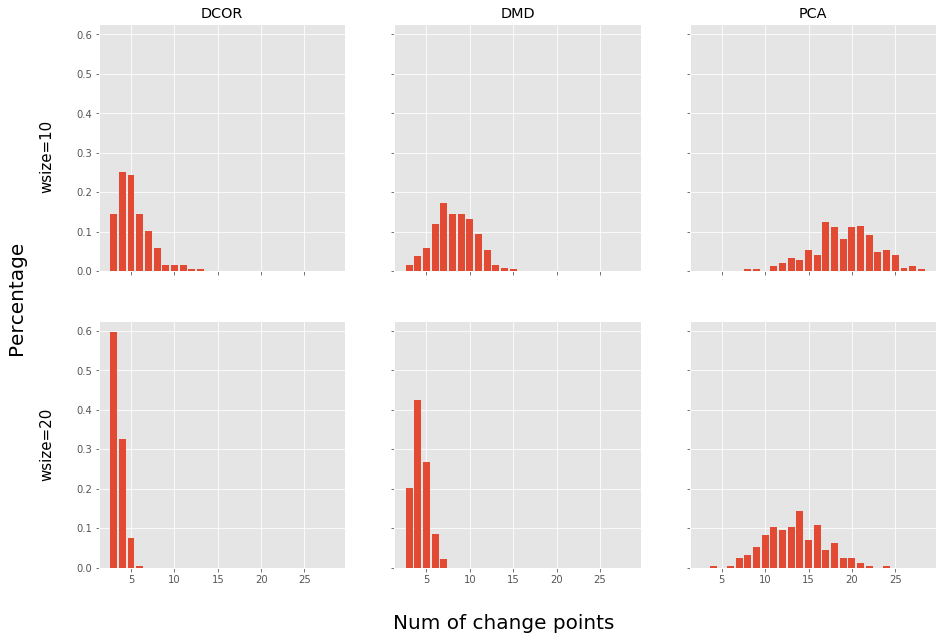

In [15]:
fig, axs= plt.subplots(nrows=2, ncols=3, sharex=True, sharey=True, figsize=(15, 10))

axs[0, 0].bar(numChgs10CT["DCOR"][0], np.array(numChgs10CT["DCOR"][1])/len(fils))
axs[0, 0].set_title("DCOR")

axs[0, 1].bar(numChgs10CT["DMD"][0], np.array(numChgs10CT["DMD"][1])/len(fils))
axs[0, 1].set_title("DMD")

axs[0, 2].bar(numChgs10CT["PCA"][0], np.array(numChgs10CT["PCA"][1])/len(fils))
axs[0, 2].set_title("PCA")


axs[1, 0].bar(numChgs20CT["DCOR"][0], np.array(numChgs20CT["DCOR"][1])/len(fils))

axs[1, 1].bar(numChgs20CT["DMD"][0], np.array(numChgs20CT["DMD"][1])/len(fils))

axs[1, 2].bar(numChgs20CT["PCA"][0], np.array(numChgs20CT["PCA"][1])/len(fils))

fig.text(0.5, 0.04, 'Num of change points', ha='center', fontsize=20)
fig.text(0.04, 0.5, 'Percentage', va='center', rotation="vertical", fontsize=20)

fig.text(0.07, 0.65, "wsize=10", rotation="vertical", fontsize=15)
fig.text(0.07, 0.25, "wsize=20", rotation="vertical", fontsize=15)

# Correlation with the 7 canonical networks

In [16]:
RsegDMDOrg = robj.r["DMDOrg"]
RsegPCAOrg = robj.r["segPCAOrg"]
RcorF = robj.r["corF.fMRI"]

In [17]:
import pandas as pd

In [18]:
fcR = pd.read_csv("../necessary files/AALICA.csv")
fcR = np.array(fcR)
fcR = fcR[:90, :]
names = ("Default", "Dorsal_Attention", "Frontoparietal", "Limbic", "Somatomotor", "Ventral_Attention", "Visual")

In [19]:
wsize = 10
rank = 6
featuresW10 = ddict(list)
corW10 = ddict(list)
for fil in tqdm(fils):
    with open(fil, "rb") as f:
        res = pickle.load(f)
    Ymat = res.DetectObj.Ymat
    d, n = Ymat.shape
    seqw = np.arange(2, n-wsize, 4)
    rSeqw = py2Rvec(seqw)
    rYmat = py2Rmat(Ymat)
    rfcR = py2Rmat(fcR)
    
    # Features and correlations for PCA
    rPCAres = RsegPCAOrg(rYmat, wsize, rSeqw, rank=rank)
    featuresW10["PCA"].append(np.array(rPCAres))
    rPCAres = RcorF(rPCAres, rfcR)
    corW10["PCA"].append(np.array(rPCAres))
    
    # Features and correlations for DMD
    rDMDres = RsegDMDOrg(rYmat, wsize, rSeqw, rank=rank)
    featuresW10["DMD"].append(np.array(rDMDres))
    rDMDres = RcorF(rDMDres, rfcR)
    corW10["DMD"].append(np.array(rDMDres))

In [20]:
wsize = 20
rank = 6
corW20 = ddict(list)
featuresW20 = ddict(list)
for fil in tqdm(fils):
    with open(fil, "rb") as f:
        res = pickle.load(f)
    Ymat = res.DetectObj.Ymat
    d, n = Ymat.shape
    seqw = np.arange(2, n-wsize, 4)
    rSeqw = py2Rvec(seqw)
    rYmat = py2Rmat(Ymat)
    rfcR = py2Rmat(fcR)
    
    # Features for PCA
    rPCAres = RsegPCAOrg(rYmat, wsize, rSeqw, rank=rank)
    featuresW20["PCA"].append(np.array(rPCAres))
    rPCAres = RcorF(rPCAres, rfcR)
    corW20["PCA"].append(np.array(rPCAres))
    
    # Features  results for DMD
    rDMDres = RsegDMDOrg(rYmat, wsize, rSeqw, rank=rank)
    featuresW20["DMD"].append(np.array(rDMDres))
    rDMDres = RcorF(rDMDres, rfcR)
    corW20["DMD"].append(np.array(rDMDres))

In [21]:
DMDw10Cors = np.array(corW10["DMD"]).reshape(-1, 7)
PCAw10Cors = np.array(corW10["PCA"]).reshape(-1, 7)
DMDw20Cors = np.array(corW20["DMD"]).reshape(-1, 7)
PCAw20Cors = np.array(corW20["PCA"]).reshape(-1, 7)
TVDNCors = np.loadtxt("./midRess/allCorrwU.txt")

absDMDw10Cors = np.abs(DMDw10Cors)
absPCAw10Cors = np.abs(PCAw10Cors)
absDMDw20Cors = np.abs(DMDw20Cors)
absPCAw20Cors = np.abs(PCAw20Cors)
absTVDNCors = np.abs(np.loadtxt("./midRess/allCorrwU.txt"))

absDMDw10CorM = np.max(absDMDw10Cors, axis=1)
absPCAw10CorM = np.max(absPCAw10Cors, axis=1)
absDMDw20CorM = np.max(absDMDw20Cors, axis=1)
absPCAw20CorM = np.max(absPCAw20Cors, axis=1)
absTVDNCorM = np.max(absTVDNCors, axis=1)

In [23]:
vs = list(absTVDNCorM) + list(absDMDw10CorM) + list(absDMDw20CorM) + list(absPCAw10CorM) + list(absPCAw20CorM)
labs = ["TVDN"]*len(absTVDNCorM) + ["DMD wsize=10"]* len(absDMDw10CorM) + ["DMD wsize=20"]* len(absDMDw20CorM) + \
       ["PCA wsize=10"]*len(absPCAw10CorM) +  ["PCA wsize=20"]*len(absPCAw20CorM)

**Violinplots of largest correlation between the features and 7 canonical networks for TVDN, DMD and PCA methods.**

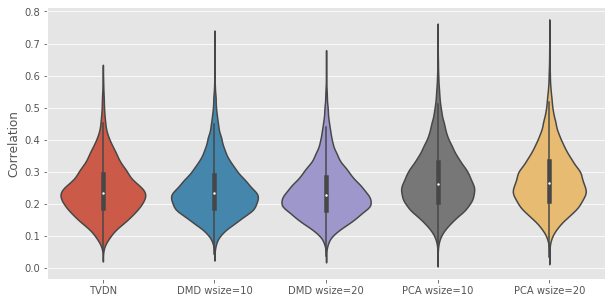

In [24]:
plt.figure(figsize=(10, 5))
sns.violinplot(y=vs, x=labs)
_ = plt.ylabel("Correlation")

In [25]:
maxIdxDMDw10 = np.argmax(DMDw10Cors, axis=1)
maxIdxPCAw10 = np.argmax(PCAw10Cors, axis=1)
maxIdxDMDw20 = np.argmax(DMDw20Cors, axis=1)
maxIdxPCAw20 = np.argmax(PCAw20Cors, axis=1)
maxIdxTVDN = np.argmax(TVDNCors, axis=1)

In [26]:
PCAw10CT = Counter(maxIdxPCAw10)
DMDw10CT = Counter(maxIdxDMDw10)
PCAw20CT = Counter(maxIdxPCAw20)
DMDw20CT = Counter(maxIdxDMDw20)
TVDNCT = Counter(maxIdxTVDN)
barPCAw10 = [PCAw10CT[i]/len(maxIdxPCAw10) for i in range(7)]
barDMDw10 = [DMDw10CT[i]/len(maxIdxDMDw10) for i in range(7)]
barPCAw20 = [PCAw20CT[i]/len(maxIdxPCAw20) for i in range(7)]
barDMDw20 = [DMDw20CT[i]/len(maxIdxDMDw20) for i in range(7)]
barTVDN = [TVDNCT[i]/len(maxIdxTVDN) for i in range(7)]

**Distributions of the largest correlation between the features and 7 canonical networks**

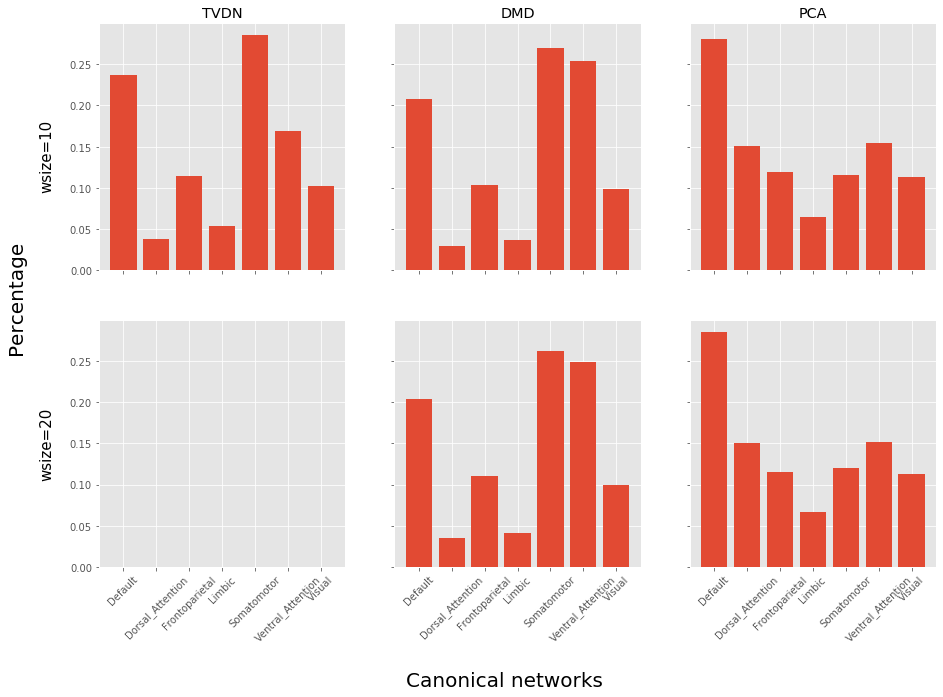

In [27]:
fig, axs = plt.subplots(nrows=2, ncols=3, sharey=True, sharex=True, figsize=(15, 10))

axs[0, 0].bar(names, barTVDN)
axs[0, 0].set_title("TVDN")
axs[0, 1].bar(names, barDMDw10)
axs[0, 1].set_title("DMD")
axs[0, 2].bar(names, barPCAw10)
axs[0, 2].set_title("PCA")

axs[1, 1].bar(names, barDMDw20)
axs[1, 2].bar(names, barPCAw20)
axs[1, 0].set_xticklabels(names, rotation=45)
axs[1, 1].set_xticklabels(names, rotation=45)
_ = axs[1, 2].set_xticklabels(names, rotation=45)

fig.text(0.5, -0.04, 'Canonical networks', ha='center', fontsize=20)
fig.text(0.04, 0.5, 'Percentage', va='center', rotation="vertical", fontsize=20)
fig.text(0.07, 0.65, "wsize=10", rotation="vertical", fontsize=15)
_ = fig.text(0.07, 0.25, "wsize=20", rotation="vertical", fontsize=15)

## Kmeans Cluster

In [28]:
from sklearn.cluster import KMeans

In [29]:
def minmax(x):
    num = x - np.min(x)
    den = np.max(x) - np.min(x)
    return num/den

In [30]:
fcR = np.array([minmax(fcR[:, i]) for i in range(7)])
fcR = fcR.T

In [31]:
fTVDNs = []
for fil in fils:
    with open(fil, "rb") as f:
        res = pickle.load(f)
    optDet = res.DetectObj
    eigVecs = optDet.midRes.eigVecs[:, :optDet.paras.r]
    kpidxs = np.concatenate([[0], optDet.ecpts]).astype(np.int)
    eigVals = optDet.RecResCur.LamMs[:, kpidxs]
    wU = eigVecs.dot(eigVals)
    for ii in range(wU.shape[1]):
        fTVDNs.append(wU[:, ii])
absfTVDNs = np.abs(np.array(fTVDNs))
absfTVDNsList =[minmax(absfTVDNs[i, :]) for i in range(absfTVDNs.shape[0])]
absfTVDNs = np.array(absfTVDNsList)

In [38]:
fPCAw10s = np.transpose(np.array(featuresW10["PCA"]), (0, 2, 1)).reshape(-1, 90)
fPCAw10sList = [minmax(fPCAw10s[i, :]) for i in range(fPCAw10s.shape[0])]
fPCAw10s = np.array(fPCAw10sList)

fDMDw10s = np.transpose(np.array(featuresW10["DMD"]), (0, 2, 1)).reshape(-1, 90)
fDMDw10sList = [minmax(fDMDw10s[i, :]) for i in range(fDMDw10s.shape[0])]
fDMDw10s = np.array(fDMDw10sList)

fPCAw20s = np.transpose(np.array(featuresW20["PCA"]), (0, 2, 1)).reshape(-1, 90)
fPCAw20sList = [minmax(fPCAw20s[i, :]) for i in range(fPCAw20s.shape[0])]
fPCAw20s = np.array(fPCAw20sList)

fDMDw20s = np.transpose(np.array(featuresW20["DMD"]), (0, 2, 1)).reshape(-1, 90)
fDMDw20sList = [minmax(fDMDw20s[i, :]) for i in range(fDMDw20s.shape[0])]
fDMDw20s = np.array(fDMDw20sList)

In [39]:
kmeans = KMeans(n_clusters=3, random_state=0)
kmeans.fit(absfTVDNs)
TVDNlabs = kmeans.labels_

kmeans = KMeans(n_clusters=3, random_state=0)
kmeans.fit(fPCAw10s)
PCAw10labs = kmeans.labels_

kmeans = KMeans(n_clusters=3, random_state=0)
kmeans.fit(fPCAw20s)
PCAw20labs = kmeans.labels_

kmeans = KMeans(n_clusters=3, random_state=0)
kmeans.fit(fDMDw10s)
DMDw10labs = kmeans.labels_

kmeans = KMeans(n_clusters=3, random_state=0)
kmeans.fit(fDMDw20s)
DMDw20labs = kmeans.labels_

In [40]:
def arr2Dic(arr):
    dic = {}
    for i, name in enumerate(names):
        dat = arr[:, i]
        dic[name] = dat
    return dic

In [41]:
TVDNCorsDF = pd.DataFrame(arr2Dic(TVDNCors))
PCAw10CorsDF = pd.DataFrame(arr2Dic(PCAw10Cors))
PCAw20CorsDF = pd.DataFrame(arr2Dic(PCAw20Cors))
DMDw10CorsDF = pd.DataFrame(arr2Dic(DMDw10Cors))
DMDw20CorsDF = pd.DataFrame(arr2Dic(DMDw20Cors))

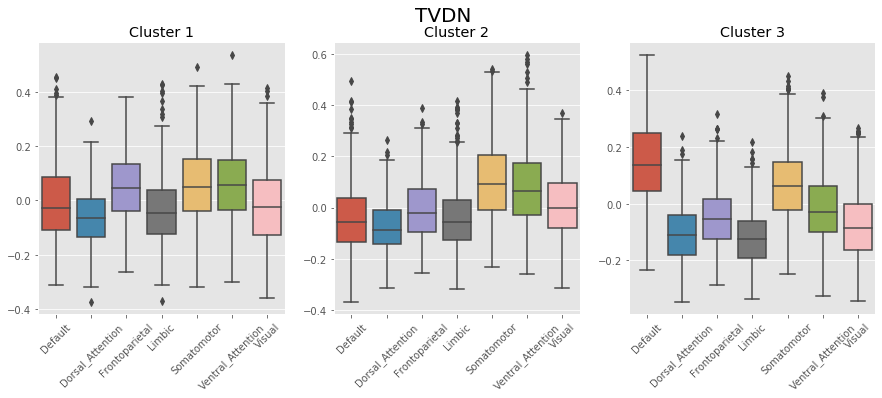

In [42]:
plt.figure(figsize=[15, 5])
for i in range(1, 4):
    plt.subplot(1, 3, i)
    plt.suptitle("TVDN", fontsize=20)
    plt.title(f"Cluster {i}")
    sns.boxplot(data=TVDNCorsDF.iloc[TVDNlabs==(i-1), :])
    plt.xticks(rotation=45)

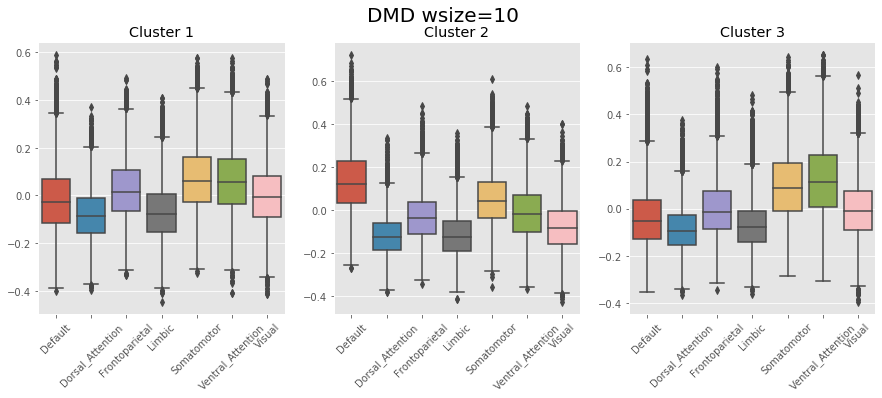

In [43]:
plt.figure(figsize=[15, 5])
for i in range(1, 4):
    plt.subplot(1, 3, i)
    plt.suptitle("DMD wsize=10", fontsize=20)
    plt.title(f"Cluster {i}")
    sns.boxplot(data=DMDw10CorsDF.iloc[DMDw10labs==(i-1), :])
    plt.xticks(rotation=45)

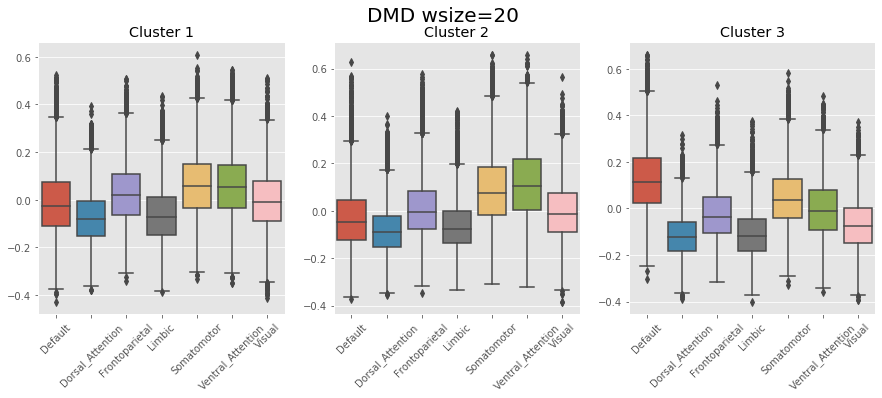

In [44]:
plt.figure(figsize=[15, 5])
for i in range(1, 4):
    plt.subplot(1, 3, i)
    plt.suptitle("DMD wsize=20", fontsize=20)
    plt.title(f"Cluster {i}")
    sns.boxplot(data=DMDw20CorsDF.iloc[DMDw20labs==(i-1), :])
    plt.xticks(rotation=45)

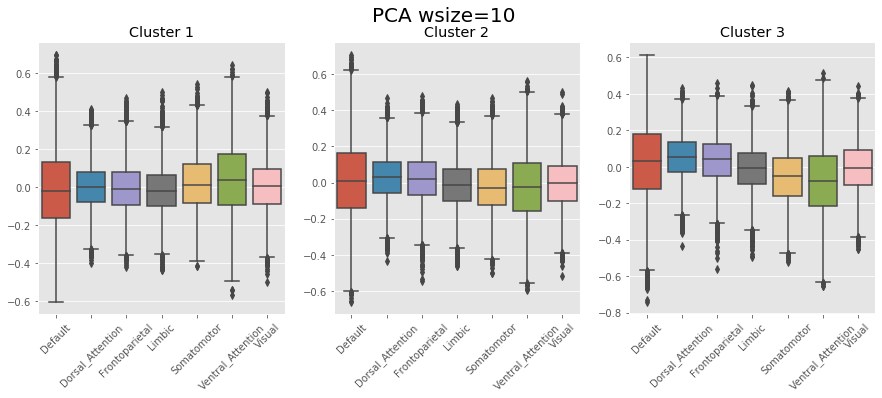

In [59]:
plt.figure(figsize=[15, 5])
for i in range(1, 4):
    plt.subplot(1, 3, i)
    plt.suptitle("PCA wsize=10", fontsize=20)
    plt.title(f"Cluster {i}")
    sns.boxplot(data=PCAw10CorsDF.iloc[PCAw10labs==(i-1), :])
    plt.xticks(rotation=45)

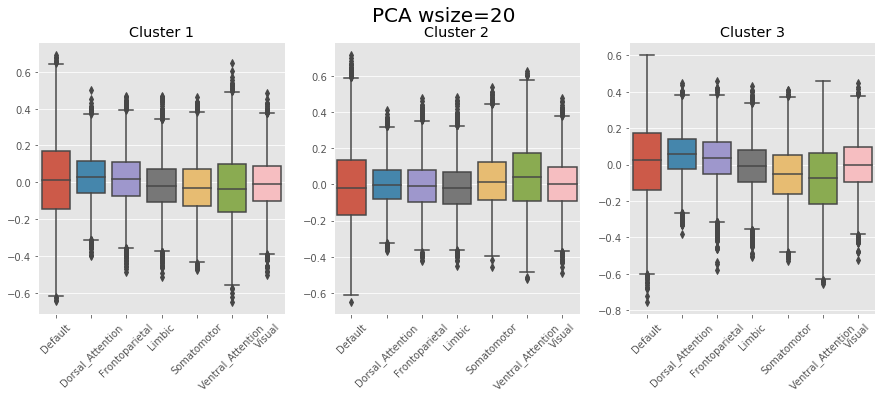

In [46]:
plt.figure(figsize=[15, 5])
for i in range(1, 4):
    plt.subplot(1, 3, i)
    plt.suptitle("PCA wsize=20", fontsize=20)
    plt.title(f"Cluster {i}")
    sns.boxplot(data=PCAw20CorsDF.iloc[PCAw20labs==(i-1), :])
    plt.xticks(rotation=45)

# Some examples

##  fMRI 5

In [47]:
idx = 4

In [48]:
with open(fils[idx], "rb") as f:
    res = pickle.load(f)

### Results for DCOR, DMD and PCA

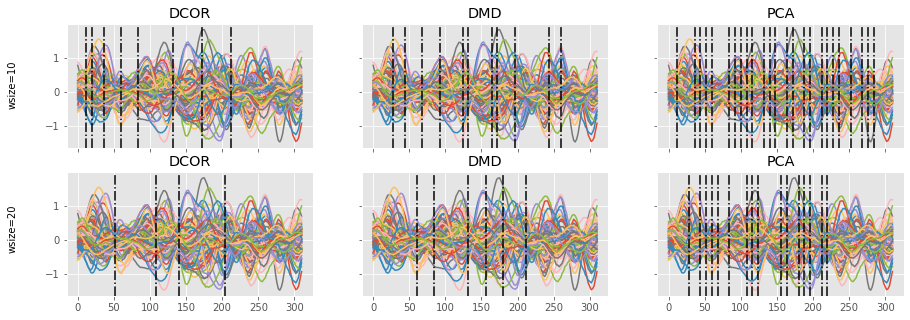

In [49]:
fig, axs= plt.subplots(nrows=2, ncols=3, sharex=True, sharey=True, figsize=(15, 5))

d, n = res.DetectObj.nYmat.shape
acTime = n / res.DetectObj.paras.freq
ajfct = n/acTime
ptime = res.DetectObj.ptime
Ymat = res.DetectObj.Ymat

for i in range(d):
    axs[0, 0].plot(ptime, Ymat[i, :], "-")
for ecpt in numChgsw10["DCOR"][idx]:
    axs[0, 0].axvline(ecpt/ajfct, color="black", linestyle="-.")
axs[0, 0].set_title("DCOR")


for i in range(d):
    axs[0, 1].plot(ptime, Ymat[i, :], "-")
for ecpt in numChgsw10["DMD"][idx]:
    axs[0, 1].axvline(ecpt/ajfct, color="black", linestyle="-.")
axs[0, 1].set_title("DMD")

for i in range(d):
    axs[0, 2].plot(ptime, Ymat[i, :], "-")
for ecpt in numChgsw10["PCA"][idx]:
    axs[0, 2].axvline(ecpt/ajfct, color="black", linestyle="-.")
axs[0, 2].set_title("PCA")

for i in range(d):
    axs[1, 0].plot(ptime, Ymat[i, :], "-")
for ecpt in numChgsw20["DCOR"][idx]:
    axs[1, 0].axvline(ecpt/ajfct, color="black", linestyle="-.")
axs[1, 0].set_title("DCOR")


for i in range(d):
    axs[1, 1].plot(ptime, Ymat[i, :], "-")
for ecpt in numChgsw20["DMD"][idx]:
    axs[1, 1].axvline(ecpt/ajfct, color="black", linestyle="-.")
axs[1, 1].set_title("DMD")

for i in range(d):
    axs[1, 2].plot(ptime, Ymat[i, :], "-")
for ecpt in numChgsw20["PCA"][idx]:
    axs[1, 2].axvline(ecpt/ajfct, color="black", linestyle="-.")
axs[1, 2].set_title("PCA")

fig.text(0.07, 0.65, "wsize=10", rotation="vertical", fontsize=10)
_ = fig.text(0.07, 0.25, "wsize=20", rotation="vertical", fontsize=10)

###  Results for TVDN

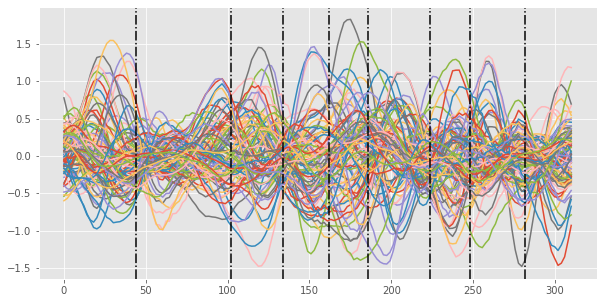

In [50]:
res.DetectObj.PlotEcpts()

## fMRI 15

In [51]:
idx = 14

In [52]:
with open(fils[idx], "rb") as f:
    res = pickle.load(f)

### Results for DCOR, DMD and PCA

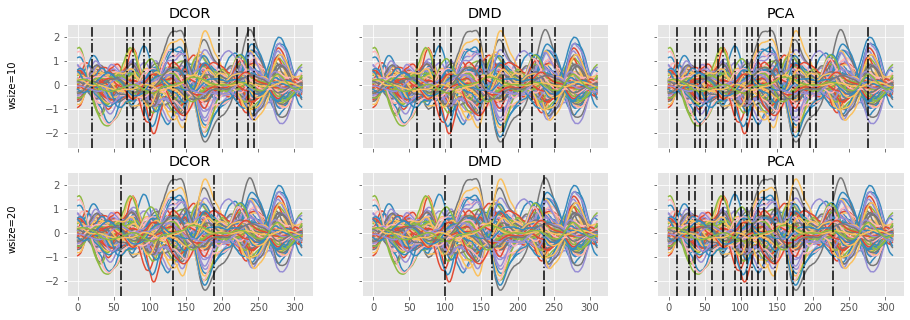

In [53]:
fig, axs= plt.subplots(nrows=2, ncols=3, sharex=True, sharey=True, figsize=(15, 5))

d, n = res.DetectObj.nYmat.shape
acTime = n / res.DetectObj.paras.freq
ajfct = n/acTime
ptime = res.DetectObj.ptime
Ymat = res.DetectObj.Ymat

for i in range(d):
    axs[0, 0].plot(ptime, Ymat[i, :], "-")
for ecpt in numChgsw10["DCOR"][idx]:
    axs[0, 0].axvline(ecpt/ajfct, color="black", linestyle="-.")
axs[0, 0].set_title("DCOR")


for i in range(d):
    axs[0, 1].plot(ptime, Ymat[i, :], "-")
for ecpt in numChgsw10["DMD"][idx]:
    axs[0, 1].axvline(ecpt/ajfct, color="black", linestyle="-.")
axs[0, 1].set_title("DMD")

for i in range(d):
    axs[0, 2].plot(ptime, Ymat[i, :], "-")
for ecpt in numChgsw10["PCA"][idx]:
    axs[0, 2].axvline(ecpt/ajfct, color="black", linestyle="-.")
axs[0, 2].set_title("PCA")

for i in range(d):
    axs[1, 0].plot(ptime, Ymat[i, :], "-")
for ecpt in numChgsw20["DCOR"][idx]:
    axs[1, 0].axvline(ecpt/ajfct, color="black", linestyle="-.")
axs[1, 0].set_title("DCOR")


for i in range(d):
    axs[1, 1].plot(ptime, Ymat[i, :], "-")
for ecpt in numChgsw20["DMD"][idx]:
    axs[1, 1].axvline(ecpt/ajfct, color="black", linestyle="-.")
axs[1, 1].set_title("DMD")

for i in range(d):
    axs[1, 2].plot(ptime, Ymat[i, :], "-")
for ecpt in numChgsw20["PCA"][idx]:
    axs[1, 2].axvline(ecpt/ajfct, color="black", linestyle="-.")
axs[1, 2].set_title("PCA")

fig.text(0.07, 0.65, "wsize=10", rotation="vertical", fontsize=10)
_ = fig.text(0.07, 0.25, "wsize=20", rotation="vertical", fontsize=10)

###  Results for TVDN

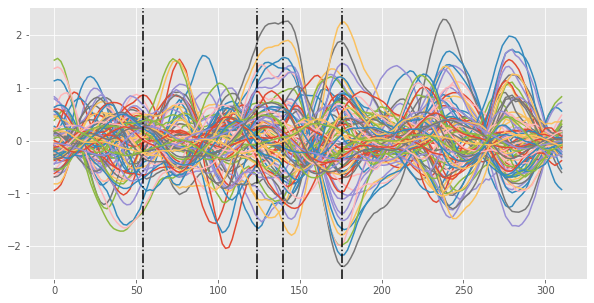

In [54]:
res.DetectObj.PlotEcpts()

## fMRI 70

In [55]:
idx = 69

In [56]:
with open(fils[idx], "rb") as f:
    res = pickle.load(f)

### Results for DCOR, DMD and PCA

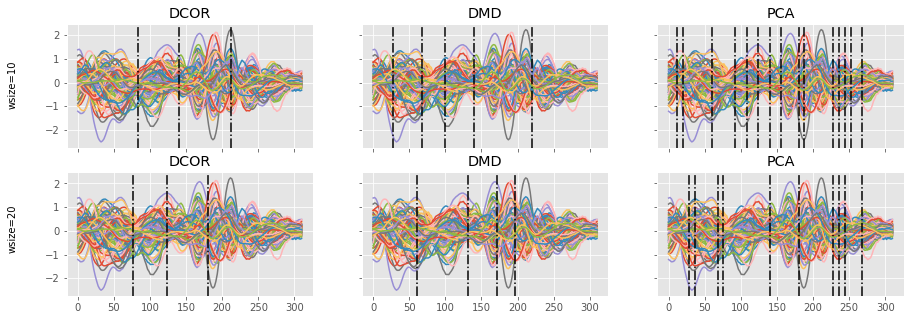

In [57]:
fig, axs= plt.subplots(nrows=2, ncols=3, sharex=True, sharey=True, figsize=(15, 5))

d, n = res.DetectObj.nYmat.shape
acTime = n / res.DetectObj.paras.freq
ajfct = n/acTime
ptime = res.DetectObj.ptime
Ymat = res.DetectObj.Ymat

for i in range(d):
    axs[0, 0].plot(ptime, Ymat[i, :], "-")
for ecpt in numChgsw10["DCOR"][idx]:
    axs[0, 0].axvline(ecpt/ajfct, color="black", linestyle="-.")
axs[0, 0].set_title("DCOR")


for i in range(d):
    axs[0, 1].plot(ptime, Ymat[i, :], "-")
for ecpt in numChgsw10["DMD"][idx]:
    axs[0, 1].axvline(ecpt/ajfct, color="black", linestyle="-.")
axs[0, 1].set_title("DMD")

for i in range(d):
    axs[0, 2].plot(ptime, Ymat[i, :], "-")
for ecpt in numChgsw10["PCA"][idx]:
    axs[0, 2].axvline(ecpt/ajfct, color="black", linestyle="-.")
axs[0, 2].set_title("PCA")

for i in range(d):
    axs[1, 0].plot(ptime, Ymat[i, :], "-")
for ecpt in numChgsw20["DCOR"][idx]:
    axs[1, 0].axvline(ecpt/ajfct, color="black", linestyle="-.")
axs[1, 0].set_title("DCOR")


for i in range(d):
    axs[1, 1].plot(ptime, Ymat[i, :], "-")
for ecpt in numChgsw20["DMD"][idx]:
    axs[1, 1].axvline(ecpt/ajfct, color="black", linestyle="-.")
axs[1, 1].set_title("DMD")

for i in range(d):
    axs[1, 2].plot(ptime, Ymat[i, :], "-")
for ecpt in numChgsw20["PCA"][idx]:
    axs[1, 2].axvline(ecpt/ajfct, color="black", linestyle="-.")
axs[1, 2].set_title("PCA")

fig.text(0.07, 0.65, "wsize=10", rotation="vertical", fontsize=10)
_ = fig.text(0.07, 0.25, "wsize=20", rotation="vertical", fontsize=10)

###  Results for TVDN

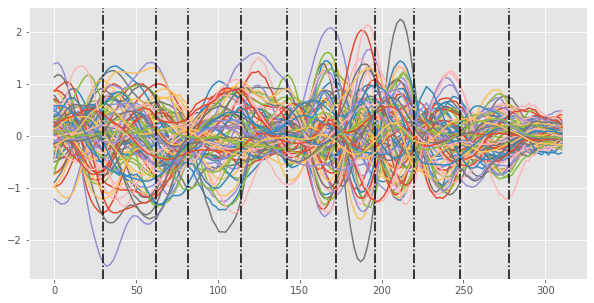

In [58]:
res.DetectObj.PlotEcpts()